# EE702: Computer Vision Assignment 1

## Imports

In [ ]:
import cv2
import math
from tqdm import *
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage.morphology import skeletonize
from scipy.ndimage import laplace

## Initialization of parameters

In [ ]:
# Defining question parameters
grid_size = 64
e1=0.0
e2=0.0
s_hat = [e1,e2,1]

noise_radiance = 0
alpha = 1

## Finding Ground Truth Depths

In [ ]:
!pip install plyfile
from plyfile import PlyData

plydata = PlyData.read('/content/bun000.ply')
vertices = np.array([list(vertex) for vertex in plydata["vertex"].data])
bunny = vertices

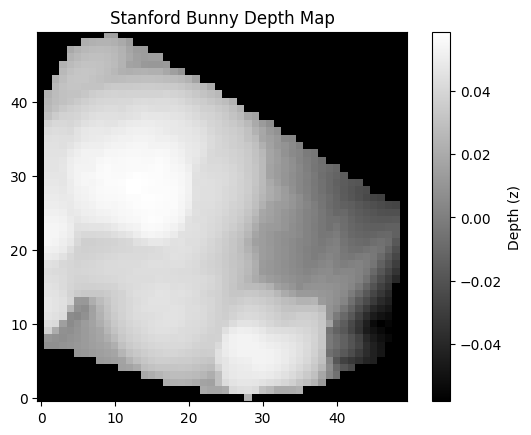

In [ ]:
from scipy.interpolate import griddata

# Extract x, y, and depth (z)
x, y, z = bunny[:, 0], bunny[:, 1], bunny[:, 2]

# Normalize x and y to fit within an image grid
x_norm = (x - x.min()) / (x.max() - x.min())  # Scale to [0, 1]
y_norm = (y - y.min()) / (y.max() - y.min())

# Define the grid resolution
grid_size = 50  # Adjust based on required resolution
grid_x, grid_y = np.mgrid[0:1:grid_size*1j, 0:1:grid_size*1j]

# Interpolate depth values onto the grid
z_ground_truth = griddata((x_norm, y_norm), z, (grid_x, grid_y), method='linear')

# Fill any NaNs with nearest values
z_ground_truth = np.nan_to_num(z_ground_truth, nan=np.nanmin(z_ground_truth))

# Plot the depth map
plt.imshow(z_ground_truth, cmap='gray', origin='lower')
plt.colorbar(label="Depth (z)")
plt.title("Stanford Bunny Depth Map")
plt.show()

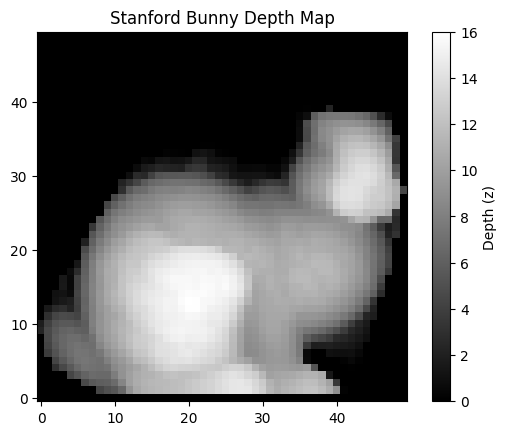

In [ ]:
z_ground_truth = z_ground_truth - 0.01
z_ground_truth[z_ground_truth < 0] = 0
z_ground_truth /= z_ground_truth.max()
z_ground_truth *= 16

# rotate z_ground_truth 90 degrees anticlockwise
z_ground_truth = np.rot90(z_ground_truth, 3)

# Plot the z_ground_truth
plt.imshow(z_ground_truth, cmap='gray', origin='lower')
plt.colorbar(label="Depth (z)")
plt.title("Stanford Bunny Depth Map")
plt.show()

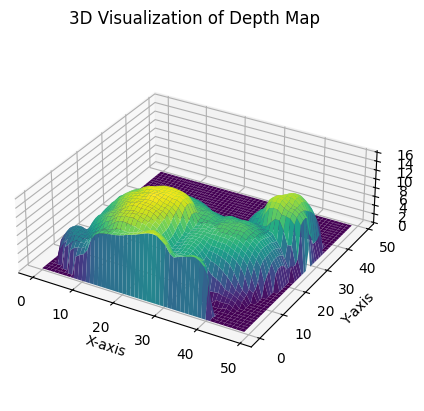

In [ ]:
#Visualization of 3D Depth Map
grid_x, grid_y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, z_ground_truth, cmap=cm.viridis)
ax.set_box_aspect((np.ptp(grid_x), np.ptp(grid_y), np.ptp(z_ground_truth)))
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Depth')
ax.set_title('3D Visualization of Depth Map')
plt.show()


## Calculating ground truth p and q

In [ ]:
ROI = z_ground_truth > 0

In [ ]:
p = np.zeros((grid_size,grid_size))
q = np.zeros((grid_size,grid_size))

for i in range(1,grid_size-1):
	for j in range(1,grid_size-1):
		p[i][j] = z_ground_truth[i][j] - z_ground_truth[i-1][j]
		q[i][j] = z_ground_truth[i][j] - z_ground_truth[i][j-1]

p *= ROI
q *= ROI

## Calculating irradiance E(x, y)

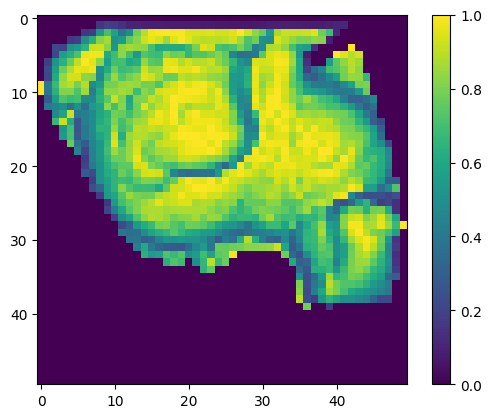

In [ ]:
# Compute E(x,y) = (n.s)^alpha from p,q,s,alpha
E = np.zeros((grid_size,grid_size))
for i in range(0,grid_size):
	for j in range(0,grid_size):
		if(ROI[i][j]):
			E[i][j] = ((-p[i,j]*s_hat[0] + -q[i,j]*s_hat[1] + 1*s_hat[2])/(((s_hat[0]**2+s_hat[1]**2+s_hat[2]**2)**0.5)*((p[i,j]**2 + q[i,j]**2 + 1**2)**0.5)))**alpha

#Ignore negative values
E[E < 0] = 0

E_max = E.max()

noise_std = noise_radiance * E_max
E += np.random.normal(0, noise_std, E.shape)

# Visualize the image irradiance
plt.imshow(E, cmap='viridis')
plt.colorbar()
plt.show()

## Estimating p and q values at boundary using E

In [ ]:
boundary = np.zeros((grid_size,grid_size))
ROI_E = E > 0
kernel = np.ones((3,3),np.uint8)
boundary = ROI_E - cv2.erode(ROI_E.astype(np.uint8),kernel,5)
boundary = cv2.erode(cv2.dilate(boundary.astype(np.uint8),kernel,3),kernel,3)
ROI_net = ROI * ROI_E
p,q = p * ROI_net , q * ROI_net

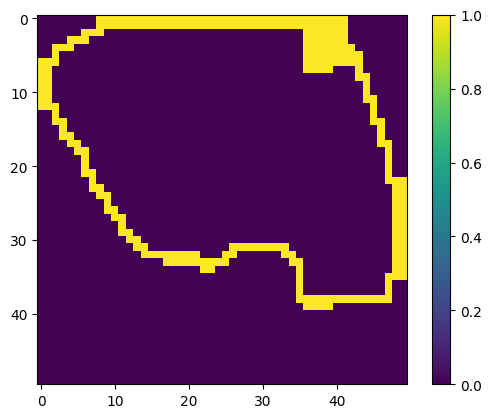

In [ ]:
plt.imshow(boundary, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
# Gradients at boundaries
diff_X, diff_Y       = deepcopy(E), deepcopy(E)
diff_X[1:-1, :] = (E[2:, :] - E[:-2, :]) / 2
diff_Y[:, 1:-1] = (E[:, 2:] - E[:, :-2]) / 2

p_hat_boundary = diff_X * boundary
q_hat_boundary = diff_Y * boundary


In [ ]:
p_hat_boundary.min()

-0.5

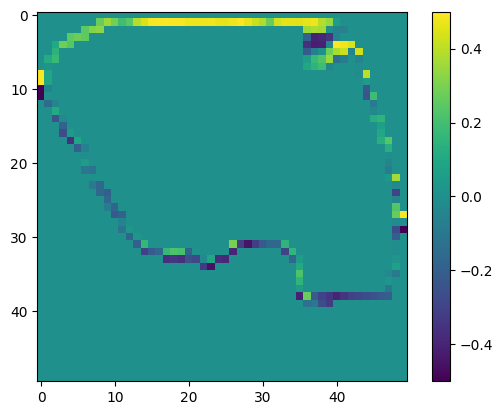

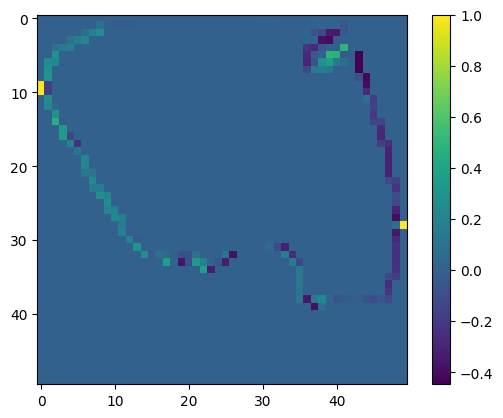

In [ ]:
# Visualize pBoundary
plt.imshow(p_hat_boundary, cmap='viridis')
plt.colorbar()
plt.show()

# Visualize qBoundary
plt.imshow(q_hat_boundary, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
pq_limit = 20000
z_limit = 20000

λ = 100		 # Regularization

In [ ]:
p_new,q_new, p_hat,q_hat = deepcopy(p_hat_boundary), deepcopy(q_hat_boundary), deepcopy(p_hat_boundary), deepcopy(q_hat_boundary)
ROI_E = E > 0

for t in tqdm(range(pq_limit)):
	for i in range(1,grid_size-1):
		for j in range(1,grid_size-1):
			if ROI_E[i][j]:
				mod_s = (s_hat[0]**2 + s_hat[1]**2 + 1)**0.5
				mod_n = (p_hat[i][j]**2 + q_hat[i][j]**2 + 1)**0.5;
				R = (-p_hat[i][j] * s_hat[0] - q_hat[i][j] * s_hat[1] + 1) / ( mod_s *mod_n)
				Rp = (-s_hat[0] - (q_hat[i][j]**2)*s_hat[0] + p_hat[i][j]*q_hat[i][j]*s_hat[1] - p_hat[i][j]*s_hat[2])/(mod_s * mod_n**3)
				Rq = (-s_hat[1] - (p_hat[i][j]**2)*s_hat[1] + p_hat[i][j]*q_hat[i][j]*s_hat[0] - q_hat[i][j]*s_hat[2])/(mod_s * mod_n**3)
				p_new[i][j] = 0.25*(p_hat[i-1][j] + p_hat[i+1][j] + p_hat[i][j-1] + p_hat[i][j+1]) - 1/λ *(E[i][j] - R)*Rp;
				q_new[i][j] = 0.25*(q_hat[i-1][j] + q_hat[i+1][j] + q_hat[i][j-1] + q_hat[i][j+1]) - 1/λ *(E[i][j] - R)*Rq;
	p_hat = (p_new*ROI_E*(1-boundary.astype(bool))) + p_hat_boundary*boundary*ROI_E
	q_hat = (q_new*ROI_E*(1-boundary.astype(bool))) + q_hat_boundary*boundary*ROI_E


100%|██████████| 20000/20000 [04:37<00:00, 72.19it/s]


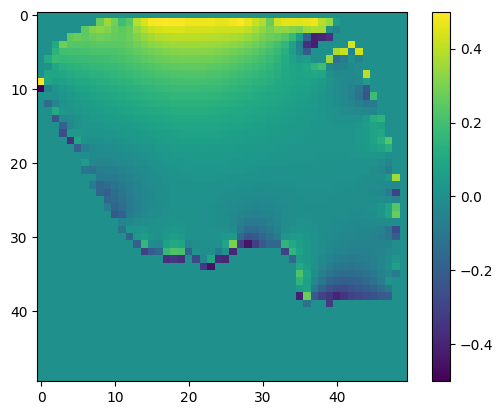

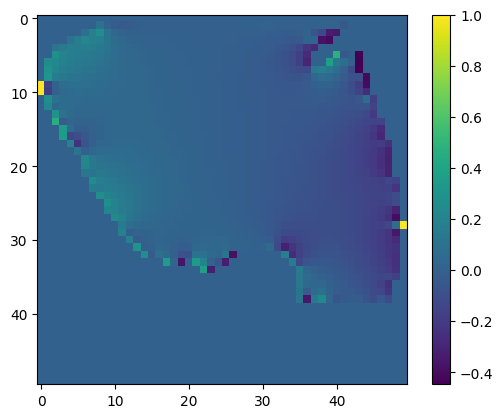

In [ ]:
# Visualize p_hat abd q_hat
plt.imshow(p_hat, cmap='viridis')
plt.colorbar()
plt.show()

plt.imshow(q_hat, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
# Depth Retrieval
Z_p   = np.zeros(p_hat.shape)
Z     = np.zeros(p_hat.shape)
# Z_p[grid_size//2][grid_size//2] = 16

p_x,q_y = np.zeros(p_hat.shape),np.zeros(q_hat.shape)

p_x[1:-1, :] = (p_hat[2:, :] - p_hat[:-2, :]) * 0.5
q_y[:, 1:-1] = (q_hat[:, 2:] - q_hat[:, :-2]) * 0.5

for iteration in tqdm(range(0,z_limit)):
	for i in range(1,p_hat.shape[0]-1):
		for j in range(1,p_hat.shape[1]-1):
			if ROI_E[i][j] == 1 :
				Z[i][j] = 0.25*( Z_p[i-1][j] + Z_p[i+1][j] + Z_p[i][j-1] + Z_p[i][j+1]) + abs(p_x[i][j]) + abs(q_y[i][j])
	Z_p = ROI_E*Z;

Z_hat = Z * ROI_E

100%|██████████| 20000/20000 [02:23<00:00, 139.67it/s]


In [ ]:
Z_hat = Z_hat * z_ground_truth.max()/abs(Z_hat).max()

In [ ]:
Z_hat.max()

16.0

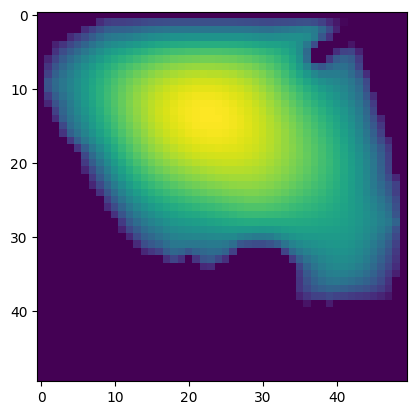

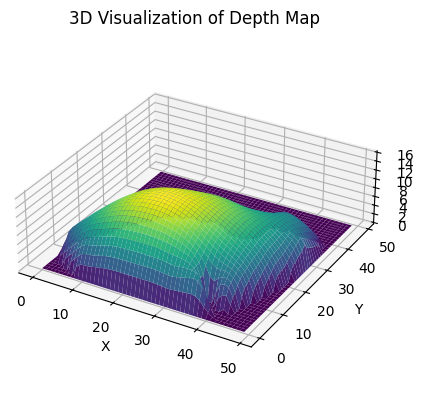

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

filename = f"defaykt"

# 2D visualization
plt.imshow(Z_hat)
plt.savefig('/content/2dmap')

# 3D visualization

X, Y = np.meshgrid(np.arange(0, grid_size), np.arange(0, grid_size))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_hat, cmap=cm.viridis)
ax.set_box_aspect((np.ptp(X), np.ptp(Y), np.ptp(Z_hat)))

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Depth Map')

# Display the plot
plt.show()

Mean Absolute Error (MAE): 1.2403433931349064
Root Mean Squared Error (RMSE): 2.2187380341301113
Maximum Absolute Error: 10.60845116698835
Relative Root Mean Squared Error (rel_RMSE): 0.42137034506237686


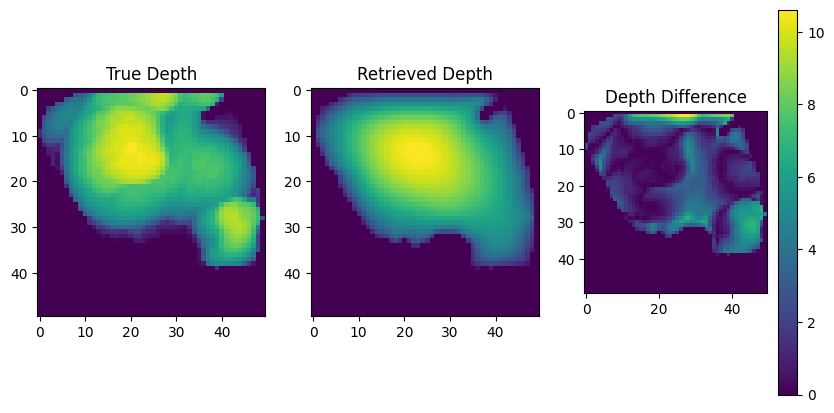

In [ ]:
# Calculate the difference between true depth and retrieved depth
depth_difference = np.abs(z_ground_truth - Z_hat)

# Calculate metrics to compare the depth maps

# 1. Mean Absolute Error (MAE)
mae = np.mean(depth_difference)
print("Mean Absolute Error (MAE):", mae)

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(depth_difference**2))
print("Root Mean Squared Error (RMSE):", rmse)

# 3. Maximum Absolute Error
max_error = np.max(depth_difference)
print("Maximum Absolute Error:", max_error)

# 4. Relative Root Mean Squared Error
rel_rmse = rmse / np.mean(z_ground_truth)
print("Relative Root Mean Squared Error (rel_RMSE):", rel_rmse)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(z_ground_truth, cmap='viridis')
plt.title('True Depth')

plt.subplot(1, 3, 2)
plt.imshow(Z_hat, cmap='viridis')
plt.title('Retrieved Depth')

plt.subplot(1, 3, 3)
plt.imshow(depth_difference, cmap='viridis')
plt.title('Depth Difference')

plt.colorbar()
plt.show()
#for no noise no epsilon